In [1]:
import kernelquantifier as kq

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA

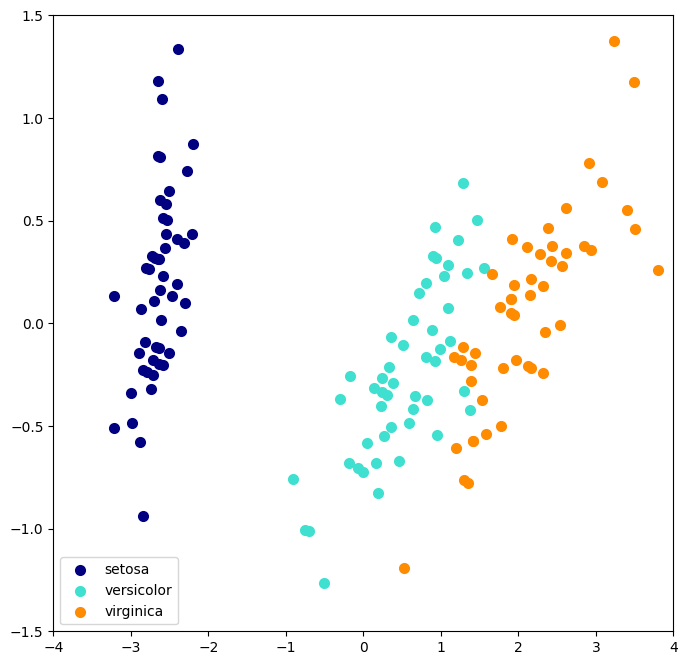

In [2]:
iris = load_iris()
X = iris.data
y = iris.target

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

colors = ["navy", "turquoise", "darkorange"]
plt.figure(figsize=(8, 8))
for color, i, target_name in zip(colors, [0, 1, 2], iris.target_names):
    plt.scatter(
        X_pca[y == i, 0],
        X_pca[y == i, 1],
        color=color,
        lw=2,
        label=target_name,
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.axis([-4, 4, -1.5, 1.5])
plt.savefig("figures/iris_pca.png")
plt.show()


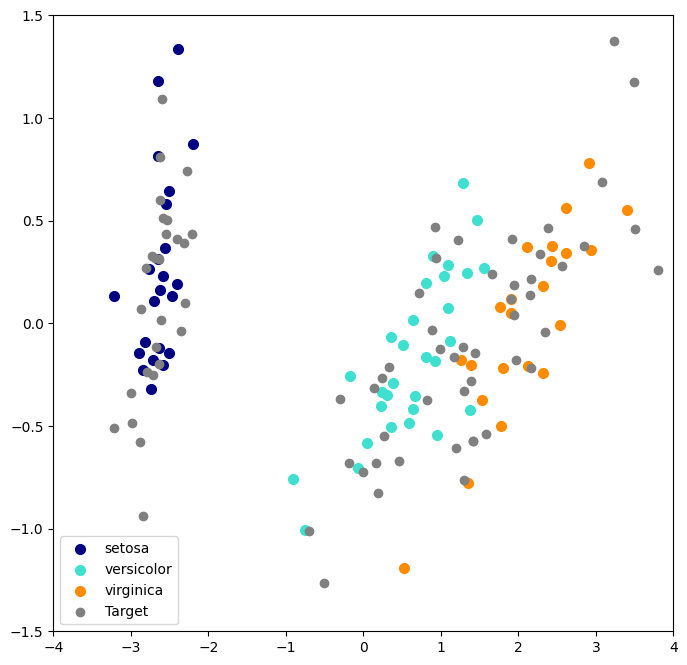

In [3]:
np.random.seed(123)
idx = np.random.choice(np.arange(X.shape[0]), 75, replace=False)
idx_inv = []
for i in range(X.shape[0]):
    if i not in idx:
        idx_inv.append(i)

# Target
Target = X[idx]
Target_Label = y[idx]

_, counts = np.unique(Target_Label, return_counts=True)
pi = counts/Target_Label.shape[0]

# Source
Source = X[idx_inv]
Source_Label = y[idx_inv]

# Plot
Source_pca = pca.transform(Source)
Target_pca = pca.transform(Target)

colors = ["navy", "turquoise", "darkorange"]
plt.figure(figsize=(8, 8))
for color, i, target_name in zip(colors, [0, 1, 2], iris.target_names):
    plt.scatter(
        Source_pca[Source_Label == i, 0],
        Source_pca[Source_Label == i, 1],
        color=color,
        lw=2,
        label=target_name,
    )
plt.scatter(
    Target_pca[:, 0],
    Target_pca[:, 1],
    color="gray",
    lw=1,
    label="Target",
)
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.axis([-4, 4, -1.5, 1.5])
plt.savefig("figures/iris_source_target.png")
plt.show()


In [4]:
device = kq.choose_device(verbose=True) 
# device = torch.device("cpu")
kq.cuda_info(device)

Running on the GPU
Using device: cuda:0

NVIDIA RTX A2000 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
11.3


In [5]:

Target = torch.from_numpy(Target)

def to_labelledCollection(X, y):
    return [torch.from_numpy(X[y == i, :]).to(device) for i in range(3)]

Source = kq.LabelledCollection(to_labelledCollection, Source, Source_Label)


In [6]:
print(Source.name_classes)
#Source.set_names_classes(["a", "b", "c", "d"]) will return an error
Source.set_names_classes(iris.target_names)
print(Source.name_classes)

[0, 1, 2]
['setosa' 'versicolor' 'virginica']


100%|██████████| 250/250 [00:00<00:00, 742.51it/s]


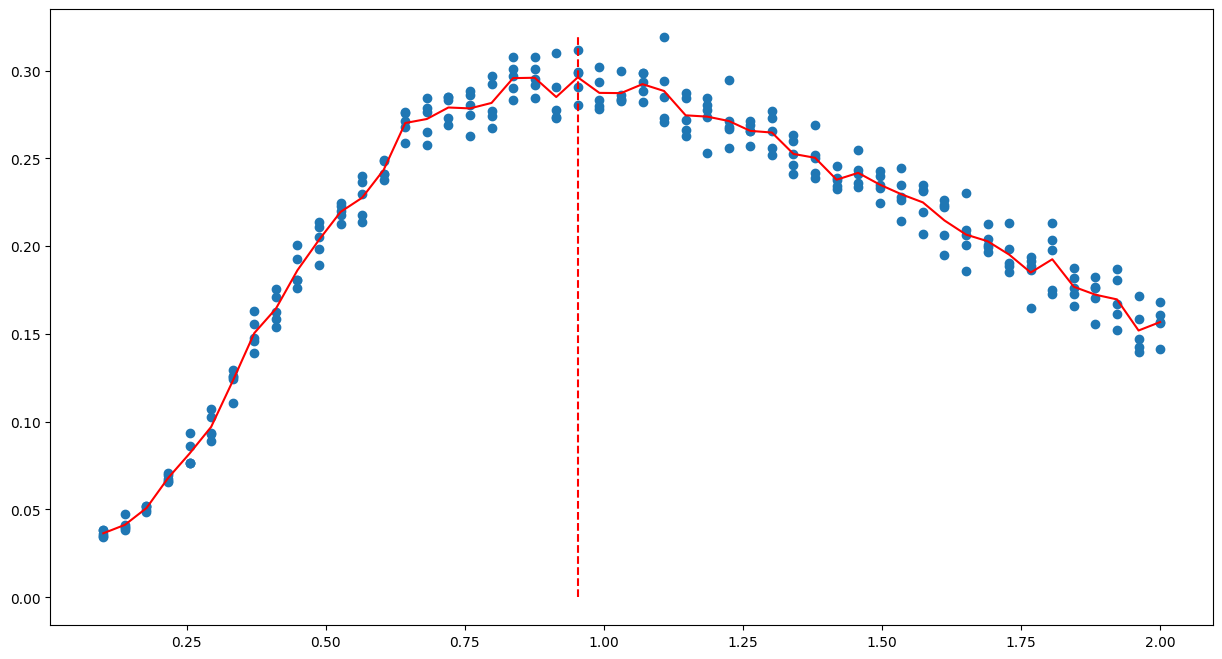

Sigma =  0.9530612244897959


In [7]:
quantifier1 = kq.KernelQuantifierRFF(kernel_type="gaussian", seed=123)
quantifier1.fit(Source, sigma=[0.1, 2], verbose=True, number_rff=1000)

In [8]:
pi_hat = quantifier1.quantify(Source, Target) 
print(f"pi_hat = {pi_hat} \npi = {pi}")
print(f"Error = {kq.KL_divergence(pi_hat, pi)}")

pi_hat = [0.3655728  0.31453998 0.31988722] 
pi = [0.36       0.26666667 0.37333333]
Error = 0.8126366858897436


100%|██████████| 50/50 [00:00<00:00, 553.53it/s]


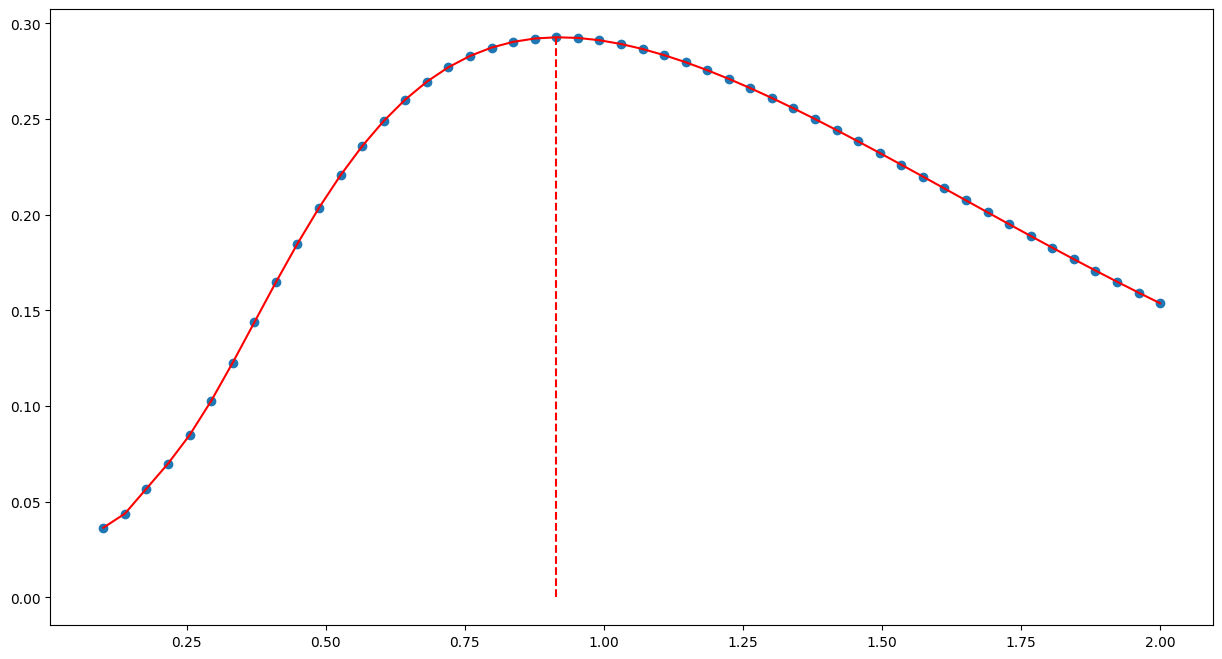

Sigma =  0.9142857142857143


In [9]:
quantifier2 = kq.KernelQuantifier(kernel_type="gaussian", seed=123)
quantifier2.fit(Source, sigma=[0.1, 2], verbose=True)

In [10]:
pi_hat = quantifier2.quantify(Source, Target)
print(f"pi_hat = {pi_hat} \npi = {pi}")
print(f"Error = {kq.KL_divergence(pi_hat, pi)}")

pi_hat = [0.36641989 0.31240374 0.32117637] 
pi = [0.36       0.26666667 0.37333333]
Error = 0.7598329173609558


In [11]:
quantifier3 = kq.GenerativeKernelQuantifier(
    kernel_type="gaussian", generator_type="independantlinear", seed=123)
quantifier3.fit(Source, sigma=1., verbose=True, number_rff=1000)

parameter = {"n_epoch": 20,
             "n_epochGM": 10,
             "lr": 0.001,
             "verbose": True,
             "initial_prop" : None}

pi_hat = quantifier3.quantify(Source, Target, **parameter)
print(f"pi_hat = {pi_hat} \npi = {pi}")
print(f"Error = {kq.KL_divergence(pi_hat, pi)}")

100%|██████████| 20/20 [00:00<00:00, 24.79it/s]

pi_hat = [0.35858852 0.30174944 0.33966204] 
pi = [0.36       0.26666667 0.37333333]
Error = 0.3781743641361017


# Plots

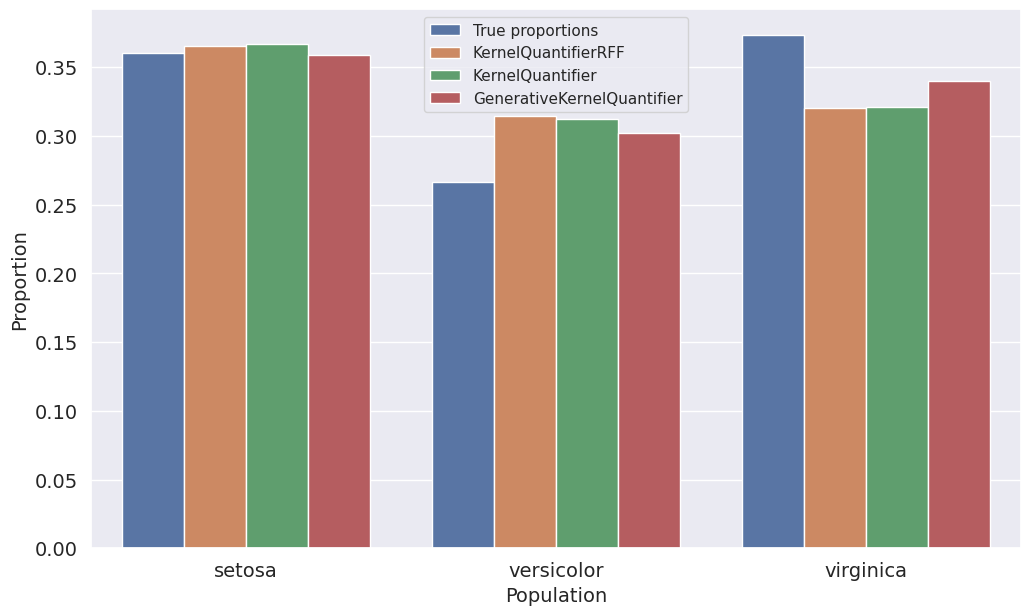

In [12]:
import kernelquantifier.plots as kqplots

kqplots.bar_plot(Source, pi, quantifier1, quantifier2, quantifier3)

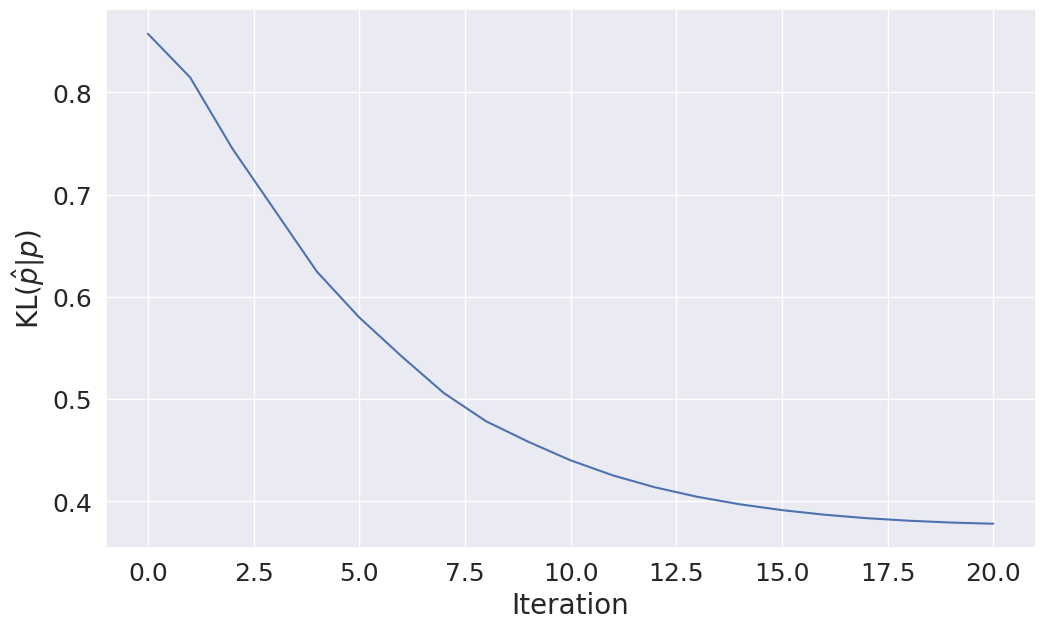

In [13]:
kqplots.KL_plot(quantifier3, pi)